In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, LSTM, Dense,
                                    Dropout, BatchNormalization, TimeDistributed,
                                    Flatten, Reshape)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [12]:
# Data Loading
def load_jena_data(filepath='jena_climate_2009_2016.csv'):
    """Load and preprocess Jena Climate Dataset"""
    df = pd.read_csv(filepath, parse_dates=['Date Time'], dayfirst=True)
    df = df.set_index('Date Time').sort_index()
    return df.resample('H').mean()  # Resample to hourly data

In [16]:
# Feature Engineering
def create_features(df, target_col='T (degC)'):
    """Create comprehensive time-series features"""
    df_fe = df.copy()

    # Rolling statistics (3h to 3-day windows)
    for window in [3, 6, 12, 24, 72]:
        df_fe[f'mean_{window}h'] = df_fe[target_col].rolling(window).mean()
        df_fe[f'std_{window}h'] = df_fe[target_col].rolling(window).std()

    # Time features with cyclical encoding
    df_fe['hour_sin'] = np.sin(2 * np.pi * df_fe.index.hour/24)
    df_fe['hour_cos'] = np.cos(2 * np.pi * df_fe.index.hour/24)
    df_fe['day_sin'] = np.sin(2 * np.pi * df_fe.index.dayofweek/7)
    df_fe['day_cos'] = np.cos(2 * np.pi * df_fe.index.dayofweek/7)

    # Difference features
    for lag in [1, 3, 6, 12]:
        df_fe[f'diff_{lag}h'] = df_fe[target_col].diff(lag)

    # Weather interactions
    df_fe['temp_pressure'] = df_fe['T (degC)'] / (df_fe['p (mbar)'] + 1e-6)
    df_fe['temp_humidity'] = df_fe['T (degC)'] * df_fe['rh (%)']

    return df_fe.dropna()

In [17]:
# Data Preparation
def prepare_data(df, target_col='T (degC)', look_back=72, forecast_horizon=12, test_size=0.2):
    """Prepare time-series sequences for modeling"""
    # Separate features and target
    X = df.drop(target_col, axis=1).values
    y = df[target_col].values.reshape(-1, 1)

    # Scaling
    feature_scaler = RobustScaler()
    X_scaled = feature_scaler.fit_transform(X)

    target_scaler = MinMaxScaler()
    y_scaled = target_scaler.fit_transform(y)

    # Create sequences
    X_seq, y_seq = [], []
    for i in range(len(X_scaled) - look_back - forecast_horizon):
        X_seq.append(X_scaled[i:i+look_back])
        y_seq.append(y_scaled[i+look_back:i+look_back+forecast_horizon])

    # Convert to arrays
    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq).reshape(-1, forecast_horizon)

    # Train-test split
    split_idx = int(len(X_seq) * (1 - test_size))
    X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
    y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

    # Reshape for models
    X_train_lr = X_train.reshape(X_train.shape[0], -1)  # Flatten for Linear Regression
    X_test_lr = X_test.reshape(X_test.shape[0], -1)

    X_train_cnnlstm = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
    X_test_cnnlstm = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

    return {
        'X_train_lr': X_train_lr, 'X_test_lr': X_test_lr,
        'X_train': X_train, 'X_test': X_test,
        'X_train_cnnlstm': X_train_cnnlstm, 'X_test_cnnlstm': X_test_cnnlstm,
        'y_train': y_train, 'y_test': y_test,
        'target_scaler': target_scaler
    }

In [18]:
# Model Architectures
def build_linear_regression():
    return LinearRegression()

def build_cnn(input_shape):
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        Conv1D(128, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
    return model

def build_lstm(input_shape):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
    return model

def build_cnn_lstm(input_shape):
    model = Sequential([
        TimeDistributed(Conv1D(64, 3, activation='relu'),
                      input_shape=input_shape),
        TimeDistributed(MaxPooling1D(2)),
        TimeDistributed(Conv1D(128, 3, activation='relu')),
        TimeDistributed(MaxPooling1D(2)),
        TimeDistributed(Flatten()),
        LSTM(128, return_sequences=True),
        LSTM(64),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
    return model

In [19]:
# Main Execution
if __name__ == "__main__":
    # Load and prepare data
    df = load_jena_data()
    df_fe = create_features(df)
    data = prepare_data(df_fe)

    # Initialize models
    models = {
        'Linear Regression': build_linear_regression(),
        'CNN': build_cnn((data['X_train'].shape[1], data['X_train'].shape[2])),
        'LSTM': build_lstm((data['X_train'].shape[1], data['X_train'].shape[2])),
        'CNN-LSTM': build_cnn_lstm((data['X_train_cnnlstm'].shape[1],
                                  data['X_train_cnnlstm'].shape[2],
                                  1))  # channels_last
    }

    # Train and evaluate
    results = []
    for name, model in models.items():
        print(f"\nTraining {name}...")

        if name == 'Linear Regression':
            model.fit(data['X_train_lr'], data['y_train'][:, 0])
            y_pred = model.predict(data['X_test_lr'])
        else:
            if 'CNN-LSTM' in name:
                X_train = data['X_train_cnnlstm']
                X_test = data['X_test_cnnlstm']
            else:
                X_train = data['X_train']
                X_test = data['X_test']

            model.fit(X_train, data['y_train'][:, 0],
                     epochs=20, batch_size=64, verbose=0,
                     validation_data=(X_test, data['y_test'][:, 0]))
            y_pred = model.predict(X_test)

        # Inverse transform predictions
        y_pred = data['target_scaler'].inverse_transform(y_pred.reshape(-1, 1))
        y_test = data['target_scaler'].inverse_transform(data['y_test'][:, 0].reshape(-1, 1))

        mae = mean_absolute_error(y_test, y_pred)
        results.append({'Model': name, 'MAE': mae})
        print(f"{name} MAE: {mae:.2f}°C")

    # Display results
    results_df = pd.DataFrame(results).sort_values('MAE')
    print("\nModel Performance Comparison:")
    print(results_df)

/tmp/ipython-input-12-595281409.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return df.resample('H').mean()  # Resample to hourly data
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential


Training Linear Regression...
Linear Regression MAE: 0.74°C

Training CNN...
436/436 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
CNN MAE: 10.69°C

Training LSTM...
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
LSTM MAE: 0.51°C

Training CNN-LSTM...
436/436 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step
CNN-LSTM MAE: 0.42°C

Model Performance Comparison:
               Model        MAE
3           CNN-LSTM   0.416420
2               LSTM   0.507324
0  Linear Regression   0.743719
1                CNN  10.694876


436/436 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
436/436 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
436/436 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step


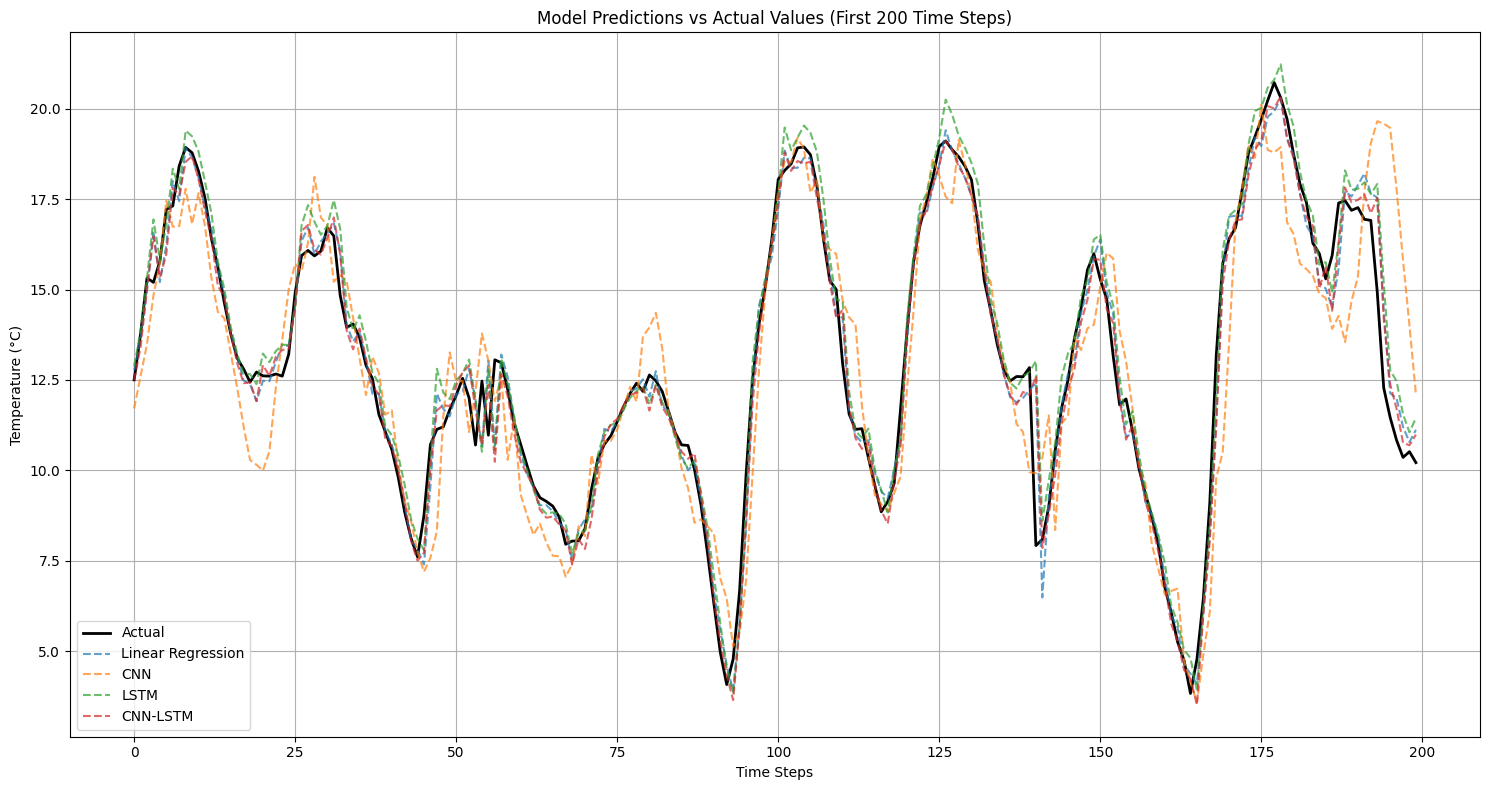

In [23]:
# Time Series Comparison Plot
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'data' dictionary and 'models' dictionary are available from previous cells
# and models have been trained.

final_predictions = {'Actual': data['target_scaler'].inverse_transform(data['y_test'][:, 0].reshape(-1, 1)).flatten()}

for name, model in models.items():
    if name == 'Linear Regression':
        X_test = data['X_test_lr']
    elif 'CNN-LSTM' in name:
        X_test = data['X_test_cnnlstm']
    else:
        X_test = data['X_test']

    y_pred = model.predict(X_test)
    final_predictions[name] = data['target_scaler'].inverse_transform(y_pred.reshape(-1, 1)).flatten()


plt.figure(figsize=(15, 8))
# Plot only a subset for better visibility, e.g., first 200 data points
subset_len = min(200, len(final_predictions['Actual']))
time_steps = np.arange(subset_len)

if 'Actual' in final_predictions: # Ensure 'Actual' data exists before plotting
    for name, values in final_predictions.items():
        if name == 'Actual':
            plt.plot(time_steps, values[:subset_len], label=name, color='black', linewidth=2)
        else:
            plt.plot(time_steps, values[:subset_len], label=name, alpha=0.7, linestyle='--')

    plt.title('Model Predictions vs Actual Values (First 200 Time Steps)')
    plt.ylabel('Temperature (°C)')
    plt.xlabel('Time Steps')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('time_series_comparison_plot.png')
    plt.show()
else:
    print("\nNo actual or predicted data to generate time series comparison plot.")

In [30]:
# Metrics Table
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

metrics = []
# Assuming 'final_predictions' and 'errors' dictionaries are available from previous cells
for name in final_predictions:
    if name != 'Actual':
        mae = mean_absolute_error(final_predictions['Actual'], final_predictions[name])
        # Check if 'errors' dict exists and contains the model name
        avg_error = np.mean(errors[name]) if name in errors else np.nan
        std_dev_error = np.std(errors[name]) if name in errors else np.nan
        metrics.append({
            'Model': name,
            'MAE': f"{mae:.2f}°C",
            'Avg Error': f"{avg_error:.2f}°C",
            'Std Dev': f"{std_dev_error:.2f}°C"
        })

results_df = pd.DataFrame(metrics).sort_values('MAE')
if not results_df.empty:
    print("\nModel Performance Metrics:")
    print(results_df.to_markdown(index=False))
else:
    print("\nNo model performance metrics to display.")


Model Performance Metrics:
| Model             | MAE     | Avg Error   | Std Dev   |
|:------------------|:--------|:------------|:----------|
| CNN-LSTM          | 0.42°C  | -0.16°C     | 0.64°C    |
| LSTM              | 0.51°C  | 0.24°C      | 0.66°C    |
| Linear Regression | 0.74°C  | 0.01°C      | 6.74°C    |
| CNN               | 10.69°C | 6.21°C      | 165.18°C  |
